In [1]:
import draw
import data_Manager
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from HyperParameters import HP
import train as tu
import generate as g
model_name = "model_weight_carrot_50_epochs"

2024-07-22 00:13:45.534743: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-22 00:13:45.640745: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-22 00:13:45.681167: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-22 00:13:45.692375: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-22 00:13:45.771581: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# model for predicting the inital state 
batch_z = tf.keras.Input(shape=(HP.latent_dim,))
initial_state = tf.keras.layers.Dense(units=(2*HP.dec_hidden_size), activation='tanh', name = "decoder_init_stat")(batch_z)
latent_to_hidden_state_model = tf.keras.Model(inputs=batch_z, outputs=initial_state)
latent_to_hidden_state_model.load_weights("model/"+model_name+".h5", by_name = True)
latent_to_hidden_state_model.summary()

I0000 00:00:1721578439.579434  260277 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721578439.667788  260277 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721578439.667828  260277 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721578439.670579  260277 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721578439.670604  260277 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_init_stat (Dense)       │ (None, 1024)           │       263,168 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 263,168 (1.00 MB)

 Trainable params: 263,168 (1.00 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
# create the LSTM for generating
"""
We have 3 input tensor. The input of the LSTM and the hidden states 
"""
decoder_input = tf.keras.Input(shape=(1, 5 + HP.latent_dim))
initial_h_input = tf.keras.Input(shape=(HP.dec_hidden_size,))
initial_c_input = tf.keras.Input(shape=(HP.dec_hidden_size,))
# now the LSTM
decoderLSTM = tf.keras.layers.LSTM(HP.dec_hidden_size, recurrent_dropout=HP.rec_dropout, 
                                    return_sequences=True, return_state=True, name = "LSTM_decoder")

# creation of the LSTM
decoder_output, h_new, c_new = decoderLSTM(decoder_input, initial_state = [initial_h_input, initial_c_input])
# dense to output. THe dimention is, as explained in the paper equal to 3 + 6*M
# 6 times M= number of mixture 
output_dimention = (3 + HP.M * 6)
distribution_output = tf.keras.layers.Dense(output_dimention, name = "output_layer")(decoder_output)

# Now we load the weights from the trained model
generator = tf.keras.models.Model([decoder_input, initial_h_input, initial_c_input], outputs =[ distribution_output , h_new, c_new])
generator.summary()
generator.load_weights("model/"+model_name+".h5", by_name = True)
generator.build(tf.TensorShape([1, None])) 

W0000 00:00:1721578444.227068  260277 gpu_kernel_to_blob_pass.cc:190] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1, 261)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM_decoder (LSTM) │ [(None, 1, 512),  │  1,585,152 │ input_layer_1[0]… │
│                     │ (None, 512),      │            │ input_layer_2[0]… │
│                     │ (None, 512)]      │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 1, 123)    │     63,099 │ LSTM_decoder[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,648,251 (6.29 MB)

 Trainable params: 1,648,251 (6.29 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
"""
Create the encoder that embed the z
"""
encoder_input = tf.keras.layers.Input(shape = (HP.max_seq_length, HP.input_dimention), name = "encoder_input" )

encoderLSTM = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(HP.enc_hidden_size, return_sequences=False,
    recurrent_dropout=HP.rec_dropout, name = "LSTM_encoder"), merge_mode='concat', name = "BI_LSTM_encoder")(encoder_input)

hidden_state_mean = tf.keras.layers.Dense(HP.latent_dim, activation='linear', name = "mean_MLP")(encoderLSTM)

hidden_state_variance = tf.keras.layers.Dense(HP.latent_dim, activation='linear', name = "variance_MLP")(encoderLSTM)
# Now we load the weights from the trained model
encoder = tf.keras.models.Model(encoder_input,[hidden_state_mean, hidden_state_variance])
encoder.summary()
encoder.load_weights("model/"+model_name+".h5", by_name = True)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 200, 5)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BI_LSTM_encoder     │ (None, 512)       │    536,576 │ encoder_input[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean_MLP (Dense)    │ (None, 256)       │    131,328 │ BI_LSTM_encoder[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ variance_MLP        │ (None, 256)       │    131,328 │ BI_LSTM_encoder[… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 799,232 (3.05 MB)

 Trainable params: 799,232 (3.05 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
HP.data_location = "data/carrot.npz"
datas = data_Manager.Data()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


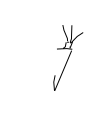

In [8]:
import random
x = datas.train[random.randint(0, len(datas.train))]
x_2 = np.expand_dims(x, axis = 0)
mean, variance = encoder.predict(x_2)
latent = np.random.rand(1,HP.latent_dim)*np.exp(variance/2)+mean
draw.draw_strokes(x, svg_filename="results/carrot_original_4.svg")

In [9]:
seq =  g.generate_sketch(generator, latent_to_hidden_state_model, temperature=0.2)
draw.draw_strokes(seq, svg_filename="results/carrot_from_IID_4.svg")

I0000 00:00:1721578461.272415  260525 service.cc:146] XLA service 0x7f7b18002900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721578461.272460  260525 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 Laptop GPU, Compute Capability 8.9
2024-07-22 00:14:21.280245: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-22 00:14:21.293564: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-07-22 00:14:21.306058: W tensorflow/core/framework/op_kernel.cc:1840] OP_REQUIRES failed at xla_ops.cc:577 : NOT_FOUND: Couldn't find a suitable version of ptxas. The following locations were considered: ./cuda_sdk_lib/bin/ptxas, /home/captain/.nix-profile/bin/ptxas, /home/captain/.local/bin/ptxas, /home/captain/.nix-profile/bin/ptxas, /home/captain/.nix-profile/bin/ptxas, /home/

NotFoundError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/home/captain/anaconda3/envs/sketch-rnn-2/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/home/captain/anaconda3/envs/sketch-rnn-2/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/captain/anaconda3/envs/sketch-rnn-2/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/captain/anaconda3/envs/sketch-rnn-2/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/captain/anaconda3/envs/sketch-rnn-2/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/captain/anaconda3/envs/sketch-rnn-2/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/captain/anaconda3/envs/sketch-rnn-2/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/home/captain/anaconda3/envs/sketch-rnn-2/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/home/captain/anaconda3/envs/sketch-rnn-2/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/captain/anaconda3/envs/sketch-rnn-2/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/captain/anaconda3/envs/sketch-rnn-2/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/captain/anaconda3/envs/sketch-rnn-2/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/captain/anaconda3/envs/sketch-rnn-2/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/captain/anaconda3/envs/sketch-rnn-2/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/captain/anaconda3/envs/sketch-rnn-2/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/captain/anaconda3/envs/sketch-rnn-2/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/captain/anaconda3/envs/sketch-rnn-2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/captain/anaconda3/envs/sketch-rnn-2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/captain/anaconda3/envs/sketch-rnn-2/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/captain/anaconda3/envs/sketch-rnn-2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/captain/anaconda3/envs/sketch-rnn-2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/captain/anaconda3/envs/sketch-rnn-2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_260277/3471917011.py", line 1, in <module>

  File "/home/captain/wsl-work/Sketch-rnn/generate.py", line 60, in generate_sketch

  File "/home/captain/anaconda3/envs/sketch-rnn-2/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/captain/anaconda3/envs/sketch-rnn-2/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 508, in predict

  File "/home/captain/anaconda3/envs/sketch-rnn-2/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 208, in one_step_on_data_distributed

Couldn't find a suitable version of ptxas. The following locations were considered: ./cuda_sdk_lib/bin/ptxas, /home/captain/.nix-profile/bin/ptxas, /home/captain/.local/bin/ptxas, /home/captain/.nix-profile/bin/ptxas, /home/captain/.nix-profile/bin/ptxas, /home/captain/.local/bin/ptxas, /home/captain/.nvm/versions/node/v18.12.0/bin/ptxas, /home/captain/anaconda3/envs/sketch-rnn-2/bin/ptxas, /home/captain/anaconda3/condabin/ptxas, /home/captain/.nix-profile/bin/ptxas, /usr/local/sbin/ptxas, /usr/local/bin/ptxas, /usr/sbin/ptxas, /usr/bin/ptxas, /sbin/ptxas, /bin/ptxas, /usr/games/ptxas, /usr/local/games/ptxas, /usr/lib/wsl/lib/ptxas, /mnt/c/Python310/Scripts/ptxas, /mnt/c/Python310/ptxas, /mnt/c/Python312/Scripts/ptxas, /mnt/c/Python312/ptxas, /mnt/c/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v12.2/bin/ptxas, /mnt/c/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v12.2/libnvvp/ptxas, /mnt/c/Windows/system32/ptxas, /mnt/c/Windows/ptxas, /mnt/c/Windows/System32/Wbem/ptxas, /mnt/c/Windows/System32/WindowsPowerShell/v1.0/ptxas, /mnt/c/Windows/System32/OpenSSH/ptxas, /mnt/c/Program Files (x86)/NVIDIA Corporation/PhysX/Common/ptxas, /mnt/c/Program Files/NVIDIA Corporation/NVIDIA NvDLISR/ptxas, /mnt/c/ProgramData/chocolatey/bin/ptxas, /mnt/c/Program Files/Microsoft VS Code/bin/ptxas, /mnt/c/Program Files/dotnet/ptxas, /mnt/c/Program Files/NVIDIA Corporation/Nsight Compute 2023.2.0/ptxas, /mnt/c/Program Files/Docker/Docker/resources/bin/ptxas, /mnt/c/Program Files/Git LFS/ptxas, /mnt/c/Program Files/Go/bin/ptxas, /mnt/c/Users/Alex Huang/go/bin/ptxas, /mnt/c/Program Files/WireGuard/ptxas, /mnt/c/Users/Alex Huang/AppData/Roaming/pypoetry/venv/Scripts/ptxas, /mnt/c/Program Files/Git/cmd/ptxas, /mnt/c/Users/Alex Huang/Desktop/unity-merge/test/bin/ptxas, /mnt/c/Users/Alex Huang/AppData/Local/Programs/git-cola/bin/ptxas, /mnt/c/Users/Alex Huang/AppData/Local/Microsoft/WindowsApps/ptxas, /mnt/c/Program Files/Oracle/VirtualBox/ptxas, /mnt/c/users/alex huang/appdata/roaming/python/python311/scripts/ptxas, /mnt/c/users/alex huang/.local/bin/ptxas, /mnt/c/Users/Alex Huang/AppData/Local/GitHubDesktop/bin/ptxas, /mnt/c/Program Files (x86)/Nmap/ptxas, /snap/bin/ptxas, /usr/local/bin/ptxas, /opt/ptxas, /usr/local/bin/ptxas, /opt/ptxas, /usr/local/cuda-12.3/bin/ptxas, /usr/local/cuda/bin/ptxas, /home/captain/anaconda3/envs/sketch-rnn-2/lib/python3.10/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc/bin/ptxas, /home/captain/anaconda3/envs/sketch-rnn-2/lib/python3.10/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc/bin/ptxas
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_data_distributed_835]